
## Problem Statement

- Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
- Write a single notebook file to run all the 3 models above for 20 epochs each
- Create these graphs:
  Graph 1: Test/Validation Loss for all 3 models together
  Graph 2: Test/Validation Accuracy for 3 models together
  graphs must have proper annotation

- Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

# Import Libraries

In [13]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from enum import Enum


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Check for GPU availability

In [16]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [17]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [18]:
# define enumerations for clarity
class NormType(Enum):  
  BATCH_NORM = 1
  LAYER_NORM = 2
  GROUP_NORM = 3

class RegularizerType(Enum):  
  NONE = 1
  L1 = 2
  L2 = 3

#define the model
class Net(nn.Module):

    def __init__(self, input_shape = (1, 28, 28), norm_type=NormType.BATCH_NORM, dropout_value=0.05):
        super(Net, self).__init__()

        # store the norm type for this instance. Control the code based on it
        self.norm_type = norm_type 
        self.dropout_value = dropout_value
        self.input_shape = input_shape
        self.changed_output_size = int(input_shape[1])
        self.norm_type = norm_type

        # Input Block
        self.changed_output_size -= 2 #based on conv2d params
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (8, self.changed_output_size, self.changed_output_size, 2)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.changed_output_size -= 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.changed_output_size /= 2

        # CONVOLUTION BLOCK 2
        self.changed_output_size -= 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 10

        self.changed_output_size -= 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 8

        self.changed_output_size -= 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
              
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)          
        x = self.convblock7(x)            

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    # return the required normalization layer based on params
    def normalization_layer(self, norm_type, dimensions):
      # dimensions => C, H, W, N  (channel, height, width, Group_size for layer norm)

      if NormType.BATCH_NORM == norm_type:
        return nn.BatchNorm2d( dimensions[0] )
      elif NormType.LAYER_NORM == norm_type:
        dimension = [int(dimensions[0]), int(dimensions[1]), int(dimensions[2])]
        return nn.LayerNorm( dimension, elementwise_affine=False ) # requires C, H, W
      elif NormType.GROUP_NORM == norm_type:
        # consider the group size in last parameter. 
        # note: Channels % group_size should be == 0
        return nn.GroupNorm( dimensions[3], dimensions[0] ) # requires group_number, channels(C)
      else:
        # default Batch Norm
        return nn.BatchNorm2d( dimensions[0] )


# Check GPU Availability

In [19]:
# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# Model Summaries

In [20]:
!pip install torchsummary
from torchsummary import summary

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]

for norm in norm_options:
  
  print(f"\nModel Summary with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Check model summary
  summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Model Summary with NormalizationType => NormType.BATCH_NORM

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,080
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 15, 24, 24]             225
        MaxPool2d-10           [-1, 15, 12, 12]               0
           Conv2d-11           [-1, 15, 10, 10]           2,025
      

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [21]:
# define train & test APIs

# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate model prediction loss
    loss = F.nll_loss(y_pred, target)

    # Handle for L1 loss
    if RegularizerType.L1 == regularizer_type:
      l1 = 0
      for p in model.parameters():
        # absolute sum of all weights
        l1 += p.abs().sum()
      
      # Total loss is sum of model prediction loss + L1 loss
      loss += (regularizer_lambda * l1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [22]:
# Invoke train & evaluate the model 

from torch.optim.lr_scheduler import StepLR

def train_test_model(model, epochs=20, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):

  # create an optimizer (SGD) with required parameters, 
  # model.parameters() - these are the model parameters to optimize, 
  # learning-rate lr=0.01 and momentum-0.9
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

  prev_train_acc = -1
  prev_test_acc = -1
  train_accuracy = 0
  test_accuracy = 0

  # run single epoch as of now.
  for epoch in range(epochs):
      print(f'Epoch: {epoch+1}')

      # train the model loaded on the device with the required optimizer
      train_accuracy = train(
                          model, device, train_loader, 
                          optimizer,
                          regularizer_lambda, 
                          regularizer_type)

      # set to the next lr params
      scheduler.step()

      # we need to evaluate on test data
      test_accuracy = test(model, device, test_loader)


      # check difference from previous accuracies for better understanding
      if -1 == prev_train_acc:
        prev_train_acc = train_accuracy
      if -1 == prev_test_acc:
        prev_test_acc = test_accuracy

      print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
      prev_train_acc = train_accuracy
      prev_test_acc = test_accuracy

  # update model metric
  model_metric = [train_losses, test_losses, train_acc, test_acc]
  return model_metric

In [23]:
import copy

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]
norm_name = ["BATCH_NORM", "LAYER_NORM", "GROUP_NORM"]

# evaluation metrics for different models
evaluation_metrics = {}
model_metric = []

print(f"\nTrain & Evaluate different model\n")

for ndx, norm in enumerate(norm_options):
  
  print(f"\nTrain & Test Model with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Map regularizer type as per the problem statement.
  regularizer = RegularizerType.NONE
  if NormType.BATCH_NORM == norm:
    regularizer = RegularizerType.NONE

  # reset to update metics for new model training
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # train the test model
  model_metric = train_test_model(
                        model, epochs=20, 
                        regularizer_lambda=0.01, 
                        regularizer_type=regularizer)

  # update final evaluation metrics for this model
  evaluation_metrics[norm_name[ndx]] = model_metric


Train & Evaluate different model


Train & Test Model with NormalizationType => NormType.BATCH_NORM

Epoch: 1


Loss=0.07075963169336319 Batch_id=468 Accuracy=92.36: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]



Test set: Average loss: 0.0726, Accuracy: 9765/10000 (97.65%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 5.285

Epoch: 2


Loss=0.03845342993736267 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0485, Accuracy: 9832/10000 (98.32%)

train_acc_diff: 5.495 test_acc_diff: 0.670 test_train_diff: 0.460

Epoch: 3


Loss=0.045731279999017715 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0404, Accuracy: 9873/10000 (98.73%)

train_acc_diff: 0.437 test_acc_diff: 0.410 test_train_diff: 0.433

Epoch: 4


Loss=0.134425550699234 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.0314, Accuracy: 9899/10000 (98.99%)

train_acc_diff: 0.110 test_acc_diff: 0.260 test_train_diff: 0.583

Epoch: 5


Loss=0.0324256606400013 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]



Test set: Average loss: 0.0334, Accuracy: 9894/10000 (98.94%)

train_acc_diff: 0.195 test_acc_diff: -0.050 test_train_diff: 0.338

Epoch: 6


Loss=0.07301528006792068 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0301, Accuracy: 9898/10000 (98.98%)

train_acc_diff: 0.097 test_acc_diff: 0.040 test_train_diff: 0.282

Epoch: 7


Loss=0.019609132781624794 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99.16%)

train_acc_diff: 0.198 test_acc_diff: 0.180 test_train_diff: 0.263

Epoch: 8


Loss=0.060213252902030945 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0299, Accuracy: 9902/10000 (99.02%)

train_acc_diff: 0.062 test_acc_diff: -0.140 test_train_diff: 0.062

Epoch: 9


Loss=0.05135178938508034 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

train_acc_diff: -0.008 test_acc_diff: 0.280 test_train_diff: 0.350

Epoch: 10


Loss=0.04345988854765892 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]



Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.14%)

train_acc_diff: 0.053 test_acc_diff: -0.160 test_train_diff: 0.137

Epoch: 11


Loss=0.07305237650871277 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

train_acc_diff: 0.012 test_acc_diff: 0.120 test_train_diff: 0.245

Epoch: 12


Loss=0.014510256238281727 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.025 test_acc_diff: -0.010 test_train_diff: 0.210

Epoch: 13


Loss=0.01145769003778696 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0219, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.113 test_acc_diff: 0.000 test_train_diff: 0.097

Epoch: 14


Loss=0.006122896447777748 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]



Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.023 test_acc_diff: 0.100 test_train_diff: 0.173

Epoch: 15


Loss=0.012411258183419704 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

train_acc_diff: -0.002 test_acc_diff: -0.030 test_train_diff: 0.145

Epoch: 16


Loss=0.0070876083336770535 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]



Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

train_acc_diff: -0.035 test_acc_diff: -0.010 test_train_diff: 0.170

Epoch: 17


Loss=0.08000084012746811 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]



Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.062 test_acc_diff: -0.020 test_train_diff: 0.088

Epoch: 18


Loss=0.006193268578499556 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

train_acc_diff: -0.003 test_acc_diff: 0.050 test_train_diff: 0.142

Epoch: 19


Loss=0.04911160469055176 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

train_acc_diff: 0.028 test_acc_diff: 0.030 test_train_diff: 0.143

Epoch: 20


Loss=0.015593089163303375 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

train_acc_diff: 0.007 test_acc_diff: -0.100 test_train_diff: 0.037


Train & Test Model with NormalizationType => NormType.LAYER_NORM

Epoch: 1


Loss=0.07449358701705933 Batch_id=468 Accuracy=90.01: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0741, Accuracy: 9806/10000 (98.06%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 8.050

Epoch: 2


Loss=0.08373702317476273 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]



Test set: Average loss: 0.0483, Accuracy: 9858/10000 (98.58%)

train_acc_diff: 7.643 test_acc_diff: 0.520 test_train_diff: 0.927

Epoch: 3


Loss=0.02859107218682766 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0376, Accuracy: 9884/10000 (98.84%)

train_acc_diff: 0.490 test_acc_diff: 0.260 test_train_diff: 0.697

Epoch: 4


Loss=0.050722211599349976 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0299, Accuracy: 9907/10000 (99.07%)

train_acc_diff: 0.225 test_acc_diff: 0.230 test_train_diff: 0.702

Epoch: 5


Loss=0.02829689346253872 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

train_acc_diff: 0.112 test_acc_diff: 0.010 test_train_diff: 0.600

Epoch: 6


Loss=0.02077789045870304 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0273, Accuracy: 9917/10000 (99.17%)

train_acc_diff: 0.107 test_acc_diff: 0.090 test_train_diff: 0.583

Epoch: 7


Loss=0.07244589179754257 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

train_acc_diff: 0.267 test_acc_diff: -0.100 test_train_diff: 0.217

Epoch: 8


Loss=0.03306614235043526 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0250, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.080 test_acc_diff: 0.220 test_train_diff: 0.357

Epoch: 9


Loss=0.02242274023592472 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

train_acc_diff: 0.007 test_acc_diff: -0.090 test_train_diff: 0.260

Epoch: 10


Loss=0.029405569657683372 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

train_acc_diff: -0.003 test_acc_diff: 0.130 test_train_diff: 0.393

Epoch: 11


Loss=0.01828162372112274 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

train_acc_diff: 0.050 test_acc_diff: -0.200 test_train_diff: 0.143

Epoch: 12


Loss=0.019912516698241234 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

train_acc_diff: -0.005 test_acc_diff: 0.140 test_train_diff: 0.288

Epoch: 13


Loss=0.040018338710069656 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.082 test_acc_diff: 0.020 test_train_diff: 0.227

Epoch: 14


Loss=0.014321587048470974 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.053 test_acc_diff: 0.030 test_train_diff: 0.203

Epoch: 15


Loss=0.02826480008661747 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

train_acc_diff: -0.018 test_acc_diff: 0.030 test_train_diff: 0.252

Epoch: 16


Loss=0.03002031147480011 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.032 test_acc_diff: 0.000 test_train_diff: 0.220

Epoch: 17


Loss=0.014898203313350677 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

train_acc_diff: 0.053 test_acc_diff: 0.070 test_train_diff: 0.237

Epoch: 18


Loss=0.024951674044132233 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

train_acc_diff: -0.037 test_acc_diff: -0.020 test_train_diff: 0.253

Epoch: 19


Loss=0.05455616116523743 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

train_acc_diff: 0.078 test_acc_diff: -0.010 test_train_diff: 0.165

Epoch: 20


Loss=0.042111098766326904 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

train_acc_diff: -0.015 test_acc_diff: 0.000 test_train_diff: 0.180


Train & Test Model with NormalizationType => NormType.GROUP_NORM

Epoch: 1


Loss=0.0871034488081932 Batch_id=468 Accuracy=89.14: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]



Test set: Average loss: 0.0666, Accuracy: 9795/10000 (97.95%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 8.815

Epoch: 2


Loss=0.08864050358533859 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.0490, Accuracy: 9846/10000 (98.46%)

train_acc_diff: 8.222 test_acc_diff: 0.510 test_train_diff: 1.103

Epoch: 3


Loss=0.12782394886016846 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0432, Accuracy: 9857/10000 (98.57%)

train_acc_diff: 0.688 test_acc_diff: 0.110 test_train_diff: 0.525

Epoch: 4


Loss=0.03394177183508873 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]



Test set: Average loss: 0.0326, Accuracy: 9895/10000 (98.95%)

train_acc_diff: 0.173 test_acc_diff: 0.380 test_train_diff: 0.732

Epoch: 5


Loss=0.03300771862268448 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

train_acc_diff: 0.273 test_acc_diff: 0.210 test_train_diff: 0.668

Epoch: 6


Loss=0.013086728751659393 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0319, Accuracy: 9894/10000 (98.94%)

train_acc_diff: -0.018 test_acc_diff: -0.220 test_train_diff: 0.467

Epoch: 7


Loss=0.03468134626746178 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.0206, Accuracy: 9922/10000 (99.22%)

train_acc_diff: 0.370 test_acc_diff: 0.280 test_train_diff: 0.377

Epoch: 8


Loss=0.02340354025363922 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

train_acc_diff: 0.083 test_acc_diff: 0.120 test_train_diff: 0.413

Epoch: 9


Loss=0.03708018362522125 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

train_acc_diff: 0.050 test_acc_diff: -0.070 test_train_diff: 0.293

Epoch: 10


Loss=0.014562682248651981 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0244, Accuracy: 9916/10000 (99.16%)

train_acc_diff: -0.007 test_acc_diff: -0.110 test_train_diff: 0.190

Epoch: 11


Loss=0.059930816292762756 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)

train_acc_diff: -0.015 test_acc_diff: 0.090 test_train_diff: 0.295

Epoch: 12


Loss=0.013665038160979748 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

train_acc_diff: 0.047 test_acc_diff: 0.080 test_train_diff: 0.328

Epoch: 13


Loss=0.009842639788985252 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

train_acc_diff: 0.105 test_acc_diff: 0.010 test_train_diff: 0.233

Epoch: 14


Loss=0.003637716406956315 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]



Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

train_acc_diff: 0.040 test_acc_diff: 0.040 test_train_diff: 0.233

Epoch: 15


Loss=0.02974279783666134 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

train_acc_diff: 0.012 test_acc_diff: 0.040 test_train_diff: 0.262

Epoch: 16


Loss=0.009541562758386135 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]



Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

train_acc_diff: 0.013 test_acc_diff: 0.010 test_train_diff: 0.258

Epoch: 17


Loss=0.009921293705701828 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

train_acc_diff: 0.035 test_acc_diff: -0.030 test_train_diff: 0.193

Epoch: 18


Loss=0.057004719972610474 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0175, Accuracy: 9940/10000 (99.40%)

train_acc_diff: 0.013 test_acc_diff: 0.000 test_train_diff: 0.180

Epoch: 19


Loss=0.016405874863266945 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)

train_acc_diff: 0.032 test_acc_diff: 0.010 test_train_diff: 0.158

Epoch: 20


Loss=0.018167752772569656 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

train_acc_diff: 0.013 test_acc_diff: 0.000 test_train_diff: 0.145



# Plot the model's learning progress

- Plot training and test accuracies of all models

<ipython-input-24-d4840e90c6c3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2, 1)
<ipython-input-24-d4840e90c6c3>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


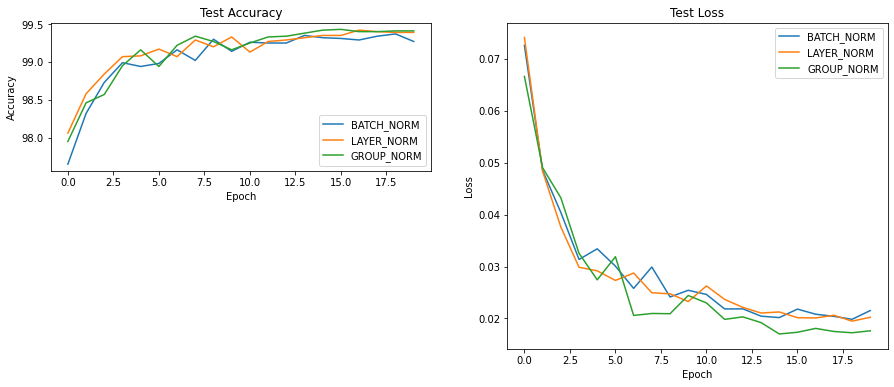

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for name in norm_name:
  
  train_losses  = evaluation_metrics[name][0]
  test_losses   = evaluation_metrics[name][1]
  train_acc     = evaluation_metrics[name][2]
  test_acc      = evaluation_metrics[name][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_name)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_name)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()